# Maps around reservoirs

## To-dos
- [ ] trend maps for xarray data
- [x] area_subset of GRACE data (instead of point subset)
- [ ] area_subset of IMERG data
- [ ] area_subset of precip data

In [1]:
func_dir = '/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/'

In [2]:
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt

sys.path.append(func_dir)
import load_data
import time_series_calcs
import plotting_functions
import area_subsets

In [3]:
fw_DA = load_data.load_CYGNSS_05()
grace_dict = load_data.load_GRACE()
res_shp = load_data.load_GRanD()
precip_DA = load_data.load_IMERG()

## Subset gpd by shp file

In [2]:
def check_for_multiple_dams(dam_name,res_shp):
    dam_row = (res_shp['DAM_NAME'].str.lower())==(dam_name.lower())
    n_rows = dam_row.sum()
    if n_rows == 0:
        print('Dam name not found')
    elif n_rows > 1:
        print('Dam name',dam_name,'is redundant.',n_rows,'entires found.')
    return res_shp[dam_row]

In [97]:
def grace_shape_subset(dam_name,res_shp,grace_dict,buffer_val=0):
    shape_row = check_for_multiple_dams(dam_name,res_shp)
    shape_poly = shape_row['geometry'].buffer(buffer_val).values[0]
    bool_series = grace_dict['mascon'].intersects(shape_poly)
    subsetted_mascon = grace_dict['mascon'][bool_series]
    subsetted_cmwe = grace_dict['cmwe'][bool_series]
    return subsetted_cmwe , subsetted_mascon

<AxesSubplot:>

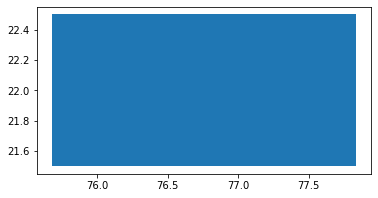

In [99]:
cmwe_i , mascon_i = grace_shape_subset('Indirasagar',res_shp,grace_dict)

## Subset xarray by shp file

In [8]:
test_row = area_subsets.check_for_multiple_dams('Merowe',res_shp)
test_row = res_shp[test_row]
test_poly = test_row['geometry'].buffer(0.1).values[0]

/global/home/users/ann_scheliga/.conda/envs/geo_jupyter_kernel/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


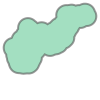

In [9]:
test_poly

## Scratchwork

In [5]:
## Trying out plotting functionality

tws = grace_dict['cmwe'].T
x_tws= list(map(time_series_calcs.toYearFraction,tws.index))
y_tws = tws
initial_tws_slopes = time_series_calcs.linregress_wrap(x_tws,y_tws)
print(initial_tws_slopes.head())

initial_tws_slopes_gdf = gpd.GeoDataFrame(pd.concat([initial_tws_slopes , grace_dict['mascon']],axis=1))

# fig , ax = plt.subplots(figsize=(12,8))
# input_gdf = initial_tws_slopes_gdf
# count = 0
# plotting_functions.statsig_map(input_gdf,ax,count, pie_row = [0.5,0.4,0.1])

           slope   intercept   r_value   p_value   std_err
labels                                                    
1426   -0.043903   88.705977 -0.039623  0.563379   0.07586
1427    -0.12197  245.336515 -0.117468  0.085735  0.070652
1428   -0.089652  180.387377 -0.093474  0.172064  0.065429
1429    0.247977 -496.908976  0.199375  0.003326  0.083511
1430    0.111738 -223.571149  0.096674  0.157785  0.078825


In [12]:
test=grace_dict['cmwe']
test.apply(time_series_calcs.linregress_wrap,axis=1,args=(x_tws))

AttributeError: 'list' object has no attribute 'columns'

In [10]:
test.apply(np.mean,axis=1)

labels
1426     0.362440
1427    -0.097099
1428    -0.013172
1429     2.080540
1430     1.271725
           ...   
13024    0.872808
13025    1.277285
13026    1.618110
13027    1.314412
13028    1.946457
Length: 11603, dtype: float64

In [6]:
## works for pd.DataFrame and linregress_wrap
# is necessary to create the x_values for linregress
def spatial_apply_func(input_df,func):
    tws = input_df.T
    x_tws= list(map(time_series_calcs.toYearFraction,tws.index))
    y_tws = tws
    initial_tws_slopes = func(x_tws,y_tws)
    return initial_tws_slopes
spatial_apply_func(grace_dict['cmwe'],time_series_calcs.linregress_wrap)

,slope,intercept,r_value,p_value,std_err
labels,,,,,
1426,-0.043903,88.705977,-0.039623,0.563379,0.07586
1427,-0.12197,245.336515,-0.117468,0.085735,0.070652
1428,-0.089652,180.387377,-0.093474,0.172064,0.065429
1429,0.247977,-496.908976,0.199375,0.003326,0.083511
1430,0.111738,-223.571149,0.096674,0.157785,0.078825
...,...,...,...,...,...
13024,0.087288,-174.770711,0.088116,0.198094,0.067611
13025,0.170931,-342.675961,0.160897,0.018233,0.071843
13026,0.260281,-522.129589,0.22192,0.001053,0.078359


In [16]:
spatial_apply_func(grace_dict['cmwe'].head(12),max)

ValueError: Unable to coerce to Series, length must be 12: given 215

In [ ]:
coords_oi = reservoir_name_to_point('Nouzhadu')

test = grace_point_subset(coords_oi)
print(test[1].iloc[0]['geometry'].exterior)
test[1]['geometry'].explore()